# Aviasurance Data Analysis
This notebook examines the aviation accident database for actionable insights about aviation incidents in the U.S. over the past four decades. This data and the incorporated analysis is key as Flatiron Partners considers whether to invest in Aviasurance.

In [3]:
import kagglehub as kg
path = kg.dataset_download("khsamaha/aviation-accident-database-synopses")

encoding = 'Windows-1252'
with open(path + '/AviationData.csv', 'r', encoding=encoding) as f:
    data = f.read()

with open('AviationData_utf8.csv', 'w', encoding='utf-8') as f:
    f.write(data)
    
import pandas as pd
base_df = pd.read_csv('AviationData_utf8.csv', low_memory=False)
df = base_df.copy(deep=True)
# Having base_df and df allow me to compare manipulated data (df) against the original dataset (base_df)

import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Exploring the Data at a High Level 
First, I want to get a sense of the dataset itself and what transformations and cleaning may need to be done to get it in a workable format. 

From looking at the columns of the dataset, certain columns have a relatively large proportion of null values (e.g., latitutde and longitude; airport name; and air carrier).

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88889 entries, 0 to 88888
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event.Id                88889 non-null  object 
 1   Investigation.Type      88889 non-null  object 
 2   Accident.Number         88889 non-null  object 
 3   Event.Date              88889 non-null  object 
 4   Location                88837 non-null  object 
 5   Country                 88663 non-null  object 
 6   Latitude                34382 non-null  object 
 7   Longitude               34373 non-null  object 
 8   Airport.Code            50249 non-null  object 
 9   Airport.Name            52790 non-null  object 
 10  Injury.Severity         87889 non-null  object 
 11  Aircraft.damage         85695 non-null  object 
 12  Aircraft.Category       32287 non-null  object 
 13  Registration.Number     87572 non-null  object 
 14  Make                    88826 non-null

In [5]:
df.describe()

,Number.of.Engines,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured
count,82805.000000,77488.000000,76379.000000,76956.000000,82977.000000
mean,1.146585,0.647855,0.279881,0.357061,5.325440
std,0.446510,5.485960,1.544084,2.235625,27.913634
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,0.000000,0.000000,0.000000,2.000000
max,8.000000,349.000000,161.000000,380.000000,699.000000


## Data Cleaning
There are several ways to improve the quality of the data and to tailor the sample to the types of incidents we care about.

Let's narrow our focus to traffic in the U.S. only.

In [6]:
df = df[df['Country'] == 'United States']

### Dropping Unhelpful Columns
I'm choosing to drop columns which are of limited use for my purposes here, e.g. those with redundant info (lat./long. when I already have location) and report status (string-based narrative data).

In [7]:
df.drop(['Latitude','Longitude','Investigation.Type',
         'Publication.Date','FAR.Description'],axis=1,inplace=True)

### Event Date
Event.Date column is not in datetime format, I'll correct this.

In [8]:
type(df['Event.Date'][1])

str

In [9]:
df['Event.Date'] = pd.to_datetime(df['Event.Date'])

In [10]:
type(df['Event.Date'][1])

pandas._libs.tslibs.timestamps.Timestamp

In [11]:
df['Event.Date'].dt.year.value_counts().sort_index(ascending=True)

1948       1
1962       1
1974       1
1977       1
1979       2
1981       1
1982    3564
1983    3524
1984    3418
1985    3066
1986    2845
1987    2770
1988    2660
1989    2495
1990    2464
1991    2404
1992    2293
1993    2250
1994    2186
1995    2214
1996    2106
1997    2032
1998    2068
1999    2073
2000    2043
2001    1901
2002    1880
2003    1946
2004    1792
2005    1852
2006    1665
2007    1837
2008    1709
2009    1604
2010    1559
2011    1612
2012    1575
2013    1313
2014    1315
2015    1313
2016    1342
2017    1331
2018    1349
2019    1303
2020    1137
2021    1181
2022    1250
Name: Event.Date, dtype: int64

The core of this dataset appears to consist of entries from 1982 onwards, I will filter the earlier ones out.

In [12]:
df = df[df['Event.Date'].dt.year >= 1982]

### Air Carrier
Of the air carrier values with non-null entries , it seems that the values are a mix of established carriers (e.g., American, United) which are likely to be helpful in my analysis and other values (e.g., YOUNGBLOOD LARRY J) which are likely to be less helpful when looking at commercial aviation.

In [13]:
df['Air.carrier'].str.title().value_counts()

Pilot                                                                                 252
United Airlines                                                                        69
American Airlines                                                                      66
Southwest Airlines Co                                                                  44
Delta Air Lines                                                                        40
                                                                                     ... 
David Harmon                                                                            1
Corporate Air, Inc. (Dba: Federal Express)                                              1
Roth Aerial Spraying Inc                                                                1
Baltimore Air Transport, Inc./Corpjet (Dba: Baltimore Air Transport, Inc./Corpjet)      1
Gary L. Bradford                                                                        1
Name: Air.

I want to eliminate as much duplication of air carriers that results from case sensitivity.

In [14]:
df['Air.carrier'] = df['Air.carrier'].str.title()

### Aircraft Make and Model
I see that Aircraft Make is likely to be a problem. For example, "Cessna" and "CESSNA" both appear here -- I will standardize the cases.

In [15]:
df.value_counts('Make')

Make
Cessna      21570
Piper       11660
CESSNA       4280
Beech        4167
PIPER        2507
            ...  
Mini Ace        1
Mini-MAX        1
Minicab         1
Minkler         1
1200            1
Length: 8001, dtype: int64

In [16]:
df['Make'].str.title().value_counts()

Cessna          25850
Piper           14167
Beech            5059
Bell             2285
Boeing           1485
                ...  
Unregistered        1
Gyaki               1
Herb Six            1
Wingo               1
Russell Heyn        1
Name: Make, Length: 7404, dtype: int64

By converting all strings in the Make column to the same case, 337 erroneously separated values were consolidated and the count of "Cessna" increased by ~74%. I'll permanently convert this column to title case and check if the same issue exists in the Model column.

In [17]:
df['Make'] = df['Make'].str.title()

In [18]:
df['Model'].value_counts()

152               2323
172               1637
172N              1136
PA-28-140          910
150                790
                  ... 
AL-6                 1
SCORPION 1670        1
KOLIBER -150A        1
SA-102.5             1
Kitfox Model 5       1
Name: Model, Length: 11443, dtype: int64

In [19]:
df['Model'].str.title().value_counts()

152            2323
172            1637
172N           1136
Pa-28-140       910
150             790
               ... 
Pa32-300D         1
Zlin 526F         1
Newport Ax8       1
206B2             1
Sr-2-600          1
Name: Model, Length: 10786, dtype: int64

Converting cases wasn't as impactful for the Model column, likely because Model values are more likely to be numeric in nature. Nonetheless, it decreased the number of unique values by ~5%, so I'll convert to title case.

In [20]:
df['Model'] = df['Model'].str.title()

### Location
I'll standardize the case for location as well.

In [21]:
df['Location'] = df['Location'].str.title()

### Amateur vs Commercial Aircraft
This analysis should only focus on commercial aviation, so I'll exclude any amateur-built aircraft.

In [22]:
df.value_counts('Amateur.Built')

Amateur.Built
No     73899
Yes     8321
dtype: int64

In [23]:
df = df[df['Amateur.Built'] == 'No'].reset_index().drop(['index'], axis=1)

### Aircraft Category
I will restrict analysis only to airplanes, helicopters, and nulls (to be cleaned).

Aircraft category has a low number of non-null values when compared to the total number of entries. I will investigate how best to clean this data, though I doubt I will be able to correct every null value.

In [24]:
df['Aircraft.Category'].value_counts()

Airplane             21120
Helicopter            2593
Glider                 472
Balloon                227
Weight-Shift           139
Powered Parachute       82
Gyrocraft               31
Ultralight              13
WSFT                     9
Blimp                    4
Powered-Lift             3
Unknown                  2
Rocket                   1
Name: Aircraft.Category, dtype: int64

In [25]:
null_aircraft_category = df[df['Aircraft.Category'].isna()]
null_aircraft_category

,Event.Id,Accident.Number,Event.Date,Location,Country,Airport.Code,Airport.Name,Injury.Severity,Aircraft.damage,Aircraft.Category,...,Schedule,Purpose.of.flight,Air.carrier,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status
2,20020909X01560,MIA82DA029,1982-01-01,"Jacksonville, Fl",United States,JAX,JACKSONVILLE INTL,Non-Fatal,Substantial,NaN,...,NaN,Personal,NaN,0.0,0.0,3.0,0.0,IMC,Cruise,Probable Cause
3,20020909X01559,FTW82DA034,1982-01-01,"Hobbs, Nm",United States,NaN,NaN,Non-Fatal,Substantial,NaN,...,NaN,Personal,NaN,0.0,0.0,0.0,1.0,VMC,Approach,Probable Cause
4,20020909X01558,ATL82DKJ10,1982-01-01,"Tuskegee, Al",United States,NaN,TUSKEGEE,Non-Fatal,Substantial,NaN,...,NaN,Personal,NaN,0.0,0.0,0.0,1.0,VMC,Landing,Probable Cause
74,20020917X01907,DCA82AA011,1982-01-13,"Washington, Dc",United States,NaN,WASHINGTON NATIONAL,Fatal(78),Destroyed,NaN,...,SCHD,Unknown,"Air Florida, Inc",78.0,6.0,3.0,0.0,IMC,Takeoff,Probable Cause
79,20020917X02486,NYC82DA022,1982-01-15,"Butler, Pa",United States,3G9,BUTLER ROE,Non-Fatal,Substantial,NaN,...,NaN,Personal,NaN,NaN,NaN,NaN,2.0,VMC,Approach,Probable Cause
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73893,20221222106486,CEN23LA068,2022-12-21,"Reserve, La",United States,NaN,NaN,Minor,NaN,NaN,...,NaN,Instructional,NaN,0.0,1.0,0.0,1.0,NaN,NaN,NaN
73894,20221227106491,ERA23LA093,2022-12-26,"Annapolis, Md",United States,NaN,NaN,Minor,NaN,NaN,...,NaN,Personal,NaN,0.0,1.0,0.0,0.0,NaN,NaN,NaN
73895,20221227106494,ERA23LA095,2022-12-26,"Hampton, Nh",United States,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN
73897,20221227106498,WPR23LA076,2022-12-26,"Morgan, Ut",United States,NaN,NaN,NaN,NaN,NaN,...,NaN,Personal,Mc Cessna 210N Llc,0.0,0.0,0.0,0.0,NaN,NaN,NaN


In [26]:
null_aircraft_category['Engine.Type'].value_counts()

Reciprocating    41761
Turbo Shaft       2124
Turbo Prop        1916
Turbo Fan         1387
Unknown           1184
Turbo Jet          506
Name: Engine.Type, dtype: int64

I suspect that engine type will be the best proxy of the existing columns for Aircraft Category. After doing some initial research, I can immediately classify all aircraft with turbo shaft as helicopters and all turbo prop, turbo fan, and turbo jet engines as airplanes. 

In [27]:
df.loc[(df['Aircraft.Category'].isna()) & (df['Engine.Type'] == 'Turbo Shaft'), 'Aircraft.Category'] = 'Helicopter'

In [28]:
df.loc[(df['Aircraft.Category'].isna()) & (df['Engine.Type'] == 'Turbo Prop'), 'Aircraft.Category'] = 'Airplane'

In [29]:
df.loc[(df['Aircraft.Category'].isna()) & (df['Engine.Type'] == 'Turbo Jet'), 'Aircraft.Category'] = 'Airplane'

In [30]:
df.loc[(df['Aircraft.Category'].isna()) & (df['Engine.Type'] == 'Turbo Fan'), 'Aircraft.Category'] = 'Airplane'

In [31]:
df.loc[(df['Aircraft.Category'].isna())]['Engine.Type'].value_counts()

Reciprocating    41761
Unknown           1184
Name: Engine.Type, dtype: int64

Unfortunately, both airplanes and helicopters can have reciprocating engines, so those entries cannot be immediately reclassified. In the rest of the dataset, there are 1210 entries of helicopters with reciprocating engines and 17387 entries of airplanes with reciprocating engines.

In [32]:
len(df[(df['Engine.Type'] =='Reciprocating') & (df['Aircraft.Category']=='Airplane')])

17387

In [33]:
len(df[(df['Engine.Type'] =='Reciprocating') & (df['Aircraft.Category']=='Helicopter')])

1210

In [34]:
df.loc[(df['Aircraft.Category'].isna()) & (df['Engine.Type']=='Reciprocating')]['Make'].value_counts()

Cessna                      17754
Piper                        9667
Beech                        3120
Mooney                        893
Grumman                       850
                            ...  
Gemini Int'L.                   1
World Wide Industries           1
Iv Inc.                         1
Cesna                           1
Evektor-Aerotechnik A.S.        1
Name: Make, Length: 500, dtype: int64

Luckily, we can further eliminate some NaNs from the aircraft category using aircraft make now.
After further research, I have discovered that Piper, Beech, and Mooney have never made helicopters. Cessna only ever made one helicopter model (the CH-1 Skyhook).  I will check for Skyhooks before seeting all Cessnas to 'Airplane'

In [35]:
df.loc[(df['Aircraft.Category'].isna()) &       
       (df['Engine.Type']=='Reciprocating') &
       (df['Make'] == 'Cessna') &
       (df['Model'].apply(lambda x: isinstance(x, str) and re.search(r'ch|skyhook', x, re.IGNORECASE) is not None))]

,Event.Id,Accident.Number,Event.Date,Location,Country,Airport.Code,Airport.Name,Injury.Severity,Aircraft.damage,Aircraft.Category,...,Schedule,Purpose.of.flight,Air.carrier,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status


Seeing no relevant Cessna entries with that name, I will set the aircraft category for each of the above to 'Airplane'.

In [36]:
df.loc[(df['Aircraft.Category'].isna()) & (df['Make'] == 'Cessna'), 'Aircraft.Category'] = 'Airplane'

In [37]:
df.loc[(df['Aircraft.Category'].isna()) & (df['Make'] == 'Piper'), 'Aircraft.Category'] = 'Airplane'

In [38]:
df.loc[(df['Aircraft.Category'].isna()) & (df['Make'] == 'Beech'), 'Aircraft.Category'] = 'Airplane'

In [39]:
df.loc[(df['Aircraft.Category'].isna()) & (df['Make'] == 'Mooney'), 'Aircraft.Category'] = 'Airplane'

In [40]:
categories_to_drop = ['Glider', 'Balloon', 'Weight-Shift',
       'Powered Parachute', 'Gyrocraft', 'Ultralight', 'WSFT', 'Blimp',
       'Powered-Lift','Unknown','Rocket']

df = df.loc[~df['Aircraft.Category'].isin(categories_to_drop)]

### Mortality Rate

While it is impossible with the current dataset to make probabilistic claims relative to the whole population of flights taken, it is helpful to look for ways to make comparisons within the dataset. Mortality rate for each flight could prove of use in making these comparisons.

In [42]:
df[['Total.Fatal.Injuries', 'Total.Serious.Injuries', 'Total.Minor.Injuries', 'Total.Uninjured']] = \
df[['Total.Fatal.Injuries', 'Total.Serious.Injuries', 'Total.Minor.Injuries', 'Total.Uninjured']].fillna(0)
df['Mortality Rate'] = ((df['Total.Fatal.Injuries'])/\
                        (df['Total.Fatal.Injuries']+df['Total.Serious.Injuries']+df['Total.Minor.Injuries']+\
                         df['Total.Uninjured'])).replace(0, np.nan).fillna(0) 

Using average mortality rate can be a useful tool for comparing between difference characteristics, the average mortality rate for aircraft with different numbers of engines is shown in the table below.

In [45]:
df.groupby('Number.of.Engines').mean()

,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Mortality Rate
Number.of.Engines,,,,,
0.0,0.158172,0.407733,0.400703,1.196837,0.104333
1.0,0.295912,0.195454,0.257048,1.120972,0.147200
2.0,0.745051,0.284043,0.386723,16.645871,0.218991
3.0,1.025641,0.708625,2.358974,106.881119,0.009263
4.0,2.267062,0.590504,1.317507,95.139466,0.102223
6.0,0.000000,0.000000,0.000000,0.000000,0.000000
8.0,0.000000,0.000000,0.000000,0.000000,0.000000


In [48]:
df['Number of Passengers'] = df['Total.Fatal.Injuries']+df['Total.Serious.Injuries']+df['Total.Serious.Injuries']+df['Total.Uninjured']

### Visualizations

In [51]:
df.to_csv('Data for Tableau.csv')

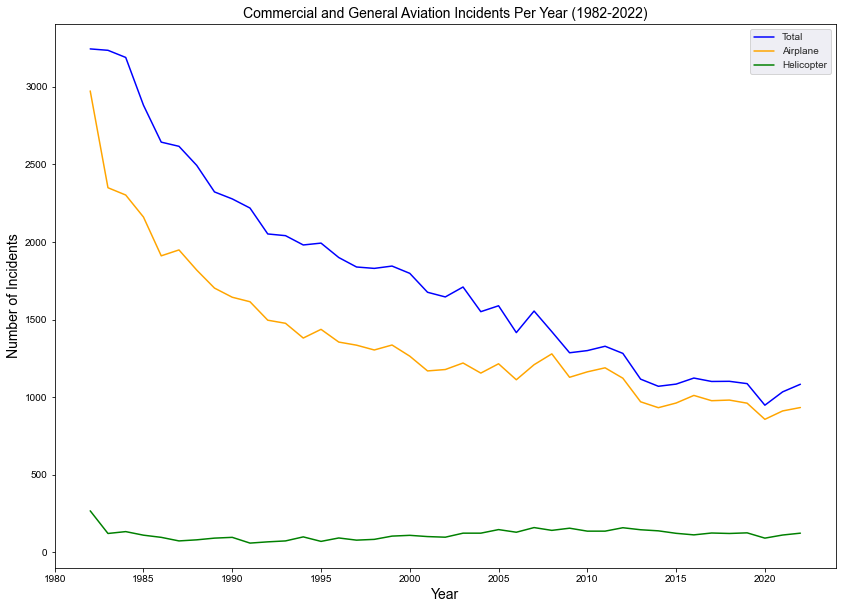

In [52]:
# Total Incidents Per Year
dates = df['Event.Date'].value_counts().sort_index(ascending=True)
counts = dates.groupby(dates.index.year).sum()
years = counts.index
# Total Airplane Incidents Per Year
airplane_dates = df.loc[df['Aircraft.Category']=='Airplane']['Event.Date'].value_counts().sort_index(ascending=True)
airplane_counts = airplane_dates.groupby(airplane_dates.index.year).sum()
airplane_years = airplane_counts.index
# Total Helicopter Incidents Per Year
helicopter_dates = df.loc[df['Aircraft.Category']=='Helicopter']['Event.Date'].value_counts().sort_index(ascending=True)
helicopter_counts = helicopter_dates.groupby(helicopter_dates.index.year).sum()
helicopter_years = helicopter_counts.index

fig,ax=plt.subplots(figsize=(14,10))

sns.set_style('darkgrid')
sns.lineplot(data=dates,x=years,y=counts, label='Total', color='blue')
sns.lineplot(data=airplane_dates,x=airplane_years,y=airplane_counts, label='Airplane', color='orange')
sns.lineplot(data=helicopter_dates,x=helicopter_years,y=helicopter_counts, label='Helicopter', color='green')

ax.set_title('Commercial and General Aviation Incidents Per Year (1982-2022)', fontsize=14)
ax.set_ylabel('Number of Incidents', fontsize=14)
ax.set_xlabel('Year', fontsize=14)
plt.show()

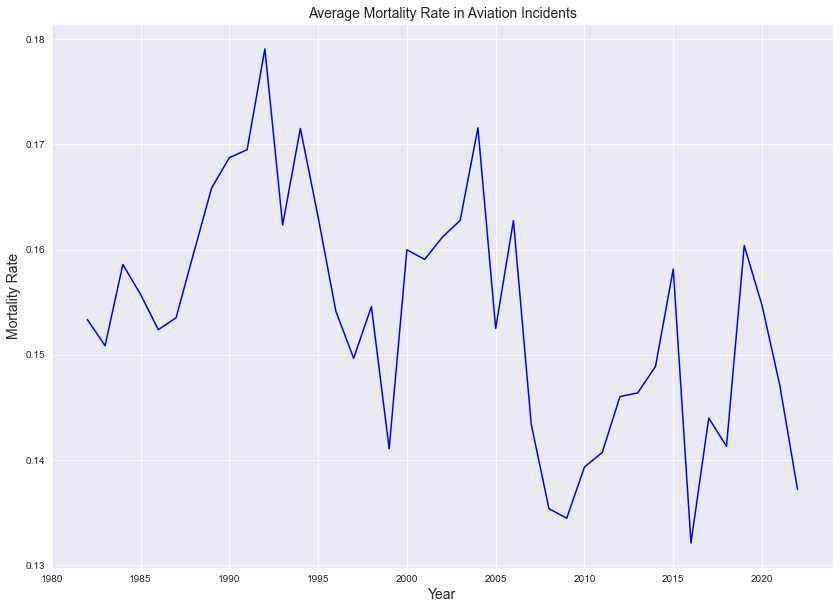

In [56]:
fig,ax=plt.subplots(figsize=(14,10))
groupbyyr = df.groupby(df['Event.Date'].dt.year).mean()

sns.set_style('darkgrid')
sns.lineplot(data=groupbyyr,
             x=groupbyyr.index, 
             y=groupbyyr['Mortality Rate'],
             color='blue')

ax.set_title('Average Mortality Rate in Aviation Incidents', fontsize=14)
ax.set_ylabel('Mortality Rate', fontsize=14)
ax.set_xlabel('Year', fontsize=14)
plt.show()

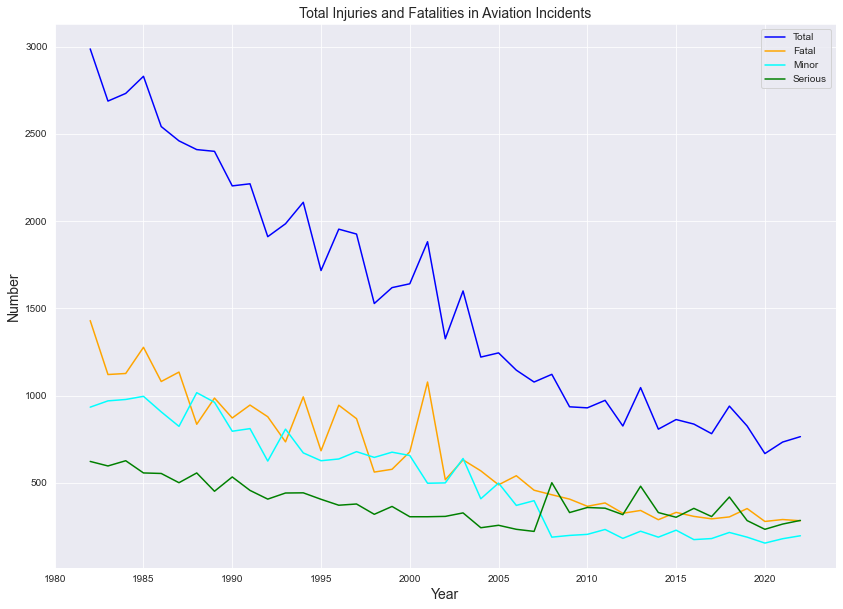

In [58]:
fig,ax=plt.subplots(figsize=(14,10))
groupbyyr_sum = df.groupby(df['Event.Date'].dt.year).sum()

sns.set_style('darkgrid')
sns.lineplot(data=groupbyyr_sum,
             x=groupbyyr_sum.index, 
             y=groupbyyr_sum[['Total.Fatal.Injuries','Total.Serious.Injuries','Total.Minor.Injuries']].sum(axis=1),
             color='blue', label='Total')

sns.lineplot(data=groupbyyr_sum,
             x=groupbyyr_sum.index, 
             y=groupbyyr_sum['Total.Fatal.Injuries'],
             color='orange', label='Fatal')

sns.lineplot(data=groupbyyr_sum,
             x=groupbyyr_sum.index, 
             y=groupbyyr_sum['Total.Minor.Injuries'],
             color='cyan', label='Minor')

sns.lineplot(data=groupbyyr_sum,
             x=groupbyyr_sum.index, 
             y=groupbyyr_sum['Total.Serious.Injuries'],
             color='green', label='Serious')

ax.set_title('Total Injuries and Fatalities in Aviation Incidents', fontsize=14)
ax.set_ylabel('Number', fontsize=14)
ax.set_xlabel('Year', fontsize=14)
plt.show()

### Visualizations by Make
All visualizations by make take the top 10 makes by total incident count over the entirety of the dataset.

In [63]:
top10_by_make = df['Make'].value_counts()[:10]

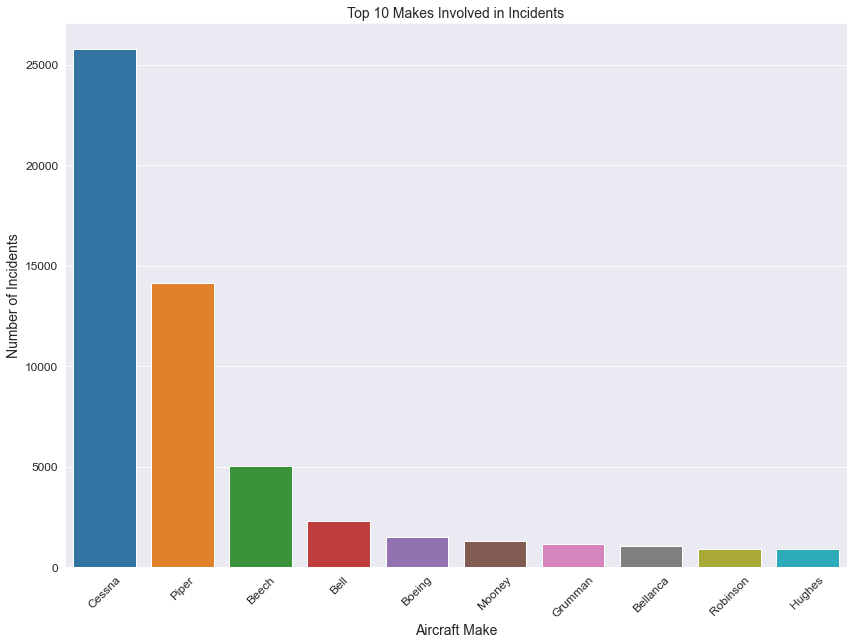

In [64]:
fig,ax=plt.subplots(figsize=(14,10))
sns.set_style('darkgrid')

sns.barplot(x=top10_by_make.index.astype(str), y=top10_by_make.values)
ax.set_title('Top 10 Makes Involved in Incidents', fontsize=14)
ax.set_xlabel('Aircraft Make', fontsize=14)
ax.set_ylabel('Number of Incidents', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=45)
plt.show()

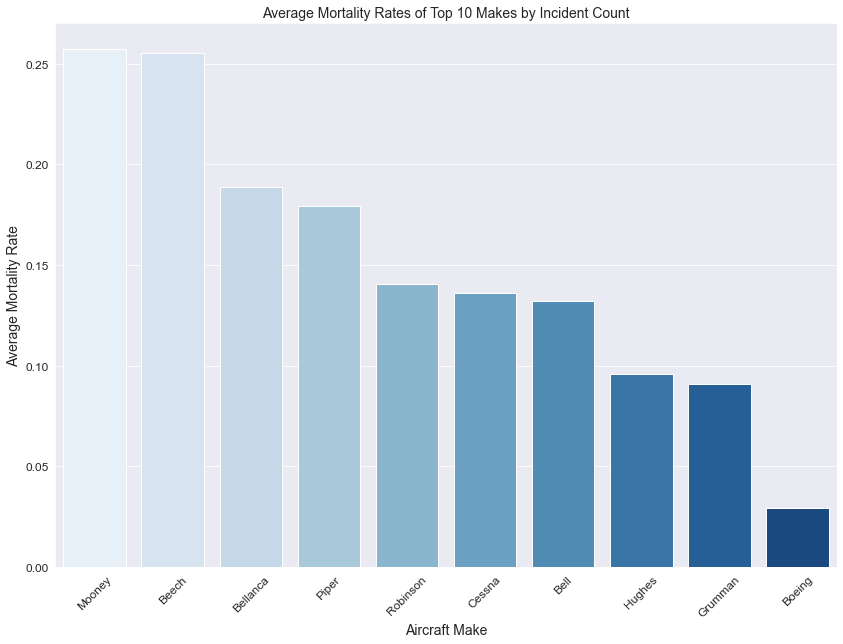

In [65]:
fig,ax=plt.subplots(figsize=(14,10))
sns.set_style('darkgrid')

top10_mortality_rates = df.groupby('Make').mean().loc[top10_by_make.index].sort_values('Mortality Rate',ascending=False)['Mortality Rate']

sns.barplot(x=top10_mortality_rates.index.astype(str), y=top10_mortality_rates.values, palette='Blues')
ax.set_title('Average Mortality Rates of Top 10 Makes by Incident Count', fontsize=14)
ax.set_xlabel('Aircraft Make', fontsize=14)
ax.set_ylabel('Average Mortality Rate', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=45)
plt.show()

In [68]:
top10_avg_rates_per_year = df.groupby([df['Event.Date'].dt.year,'Make']).mean()['Mortality Rate'].unstack().T.loc[top10_by_make.index]

In [69]:
stddev_mortality_rate = pd.DataFrame({'Make': top10_avg_rates_per_year.index,
              'Std Dev': [np.std(top10_avg_rates_per_year.loc[x]) for x in top10_avg_rates_per_year.index]
             }
)

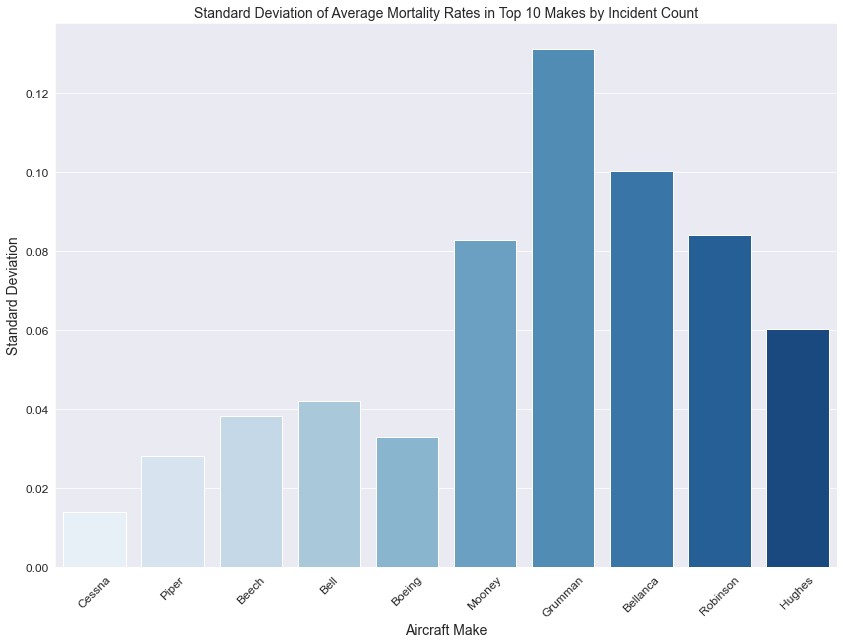

In [70]:
fig,ax=plt.subplots(figsize=(14,10))
sns.set_style('darkgrid')

sns.barplot(x=stddev_mortality_rate['Make'].astype(str),y=stddev_mortality_rate['Std Dev'].astype(float),palette='Blues')
ax.set_title('Standard Deviation of Average Mortality Rates in Top 10 Makes by Incident Count', fontsize=14)
ax.set_xlabel('Aircraft Make', fontsize=14)
ax.set_ylabel('Standard Deviation', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=45)
plt.show()

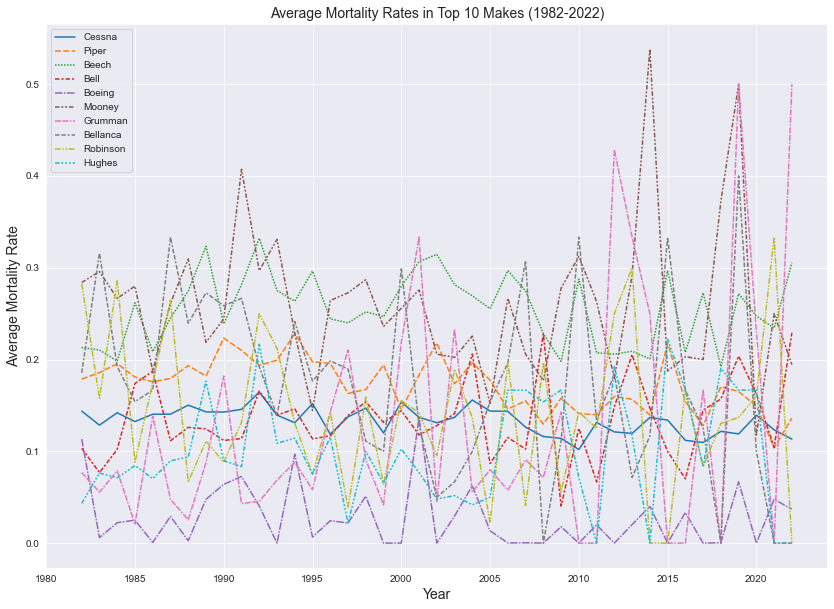

In [71]:
fig,ax=plt.subplots(figsize=(14,10))

sns.set_style('darkgrid')
sns.lineplot(data=top10_avg_rates_per_year.T)

ax.set_title('Average Mortality Rates in Top 10 Makes (1982-2022)', fontsize=14)
ax.set_ylabel('Average Mortality Rate', fontsize=14)
ax.set_xlabel('Year', fontsize=14)
plt.show()

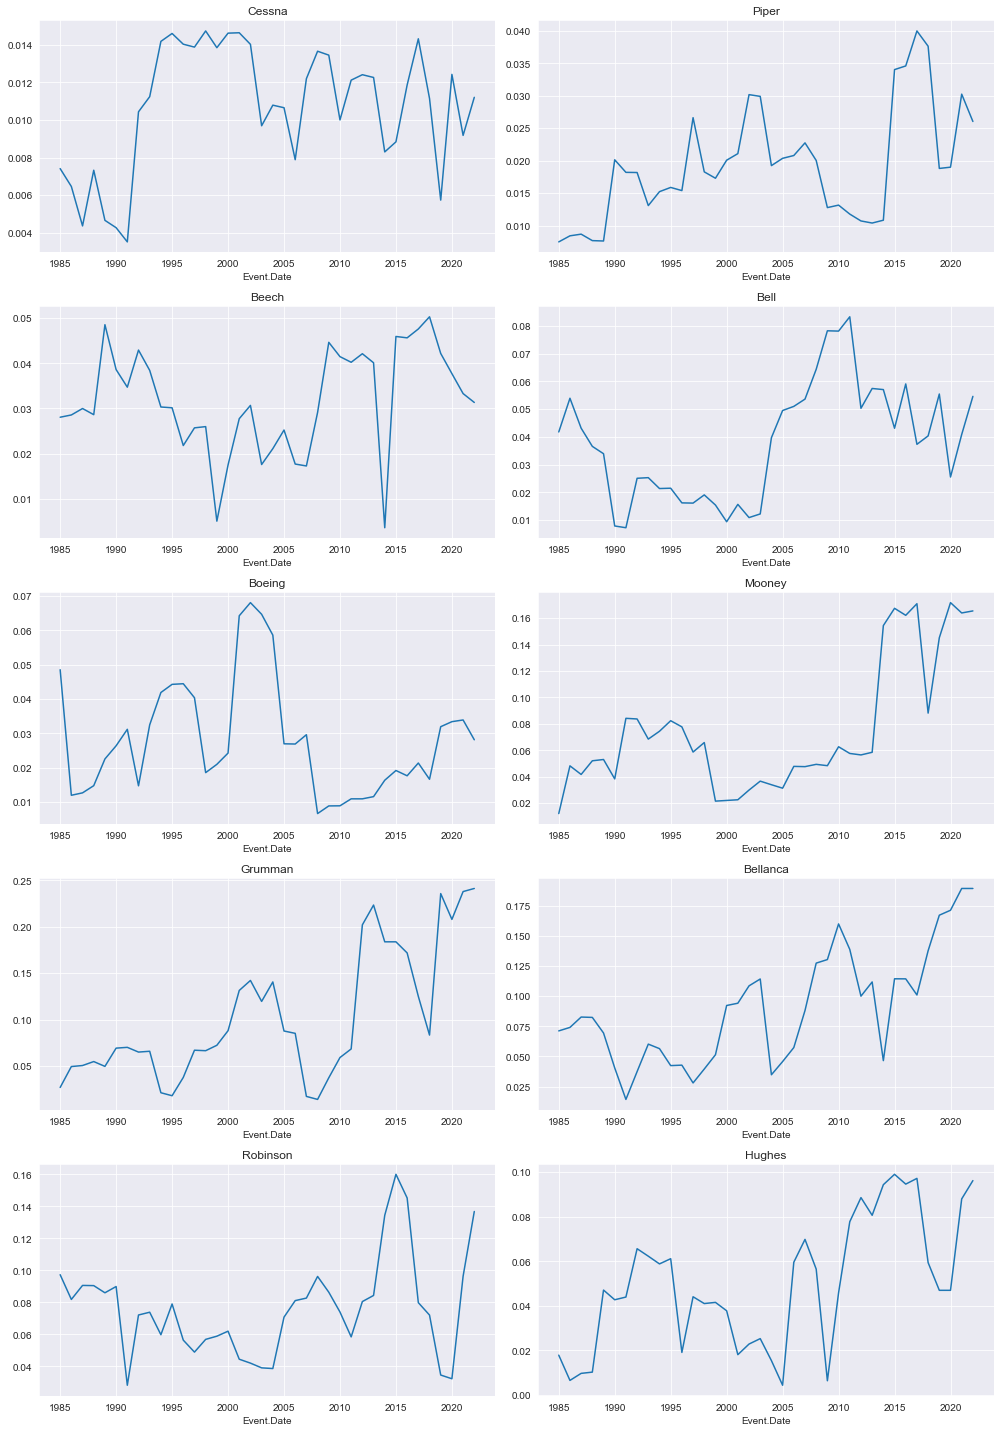

In [72]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(14, 20))  
sns.set_style('darkgrid')

axes = axes.flatten()  
for idx, col in enumerate(top10_avg_rates_per_year.T.columns):
    ax = axes[idx]  
    top10_avg_rates_per_year.T[col].rolling(window=4).std().plot(ax=ax)
    ax.set_title(col)  
    
plt.tight_layout() 
plt.show()

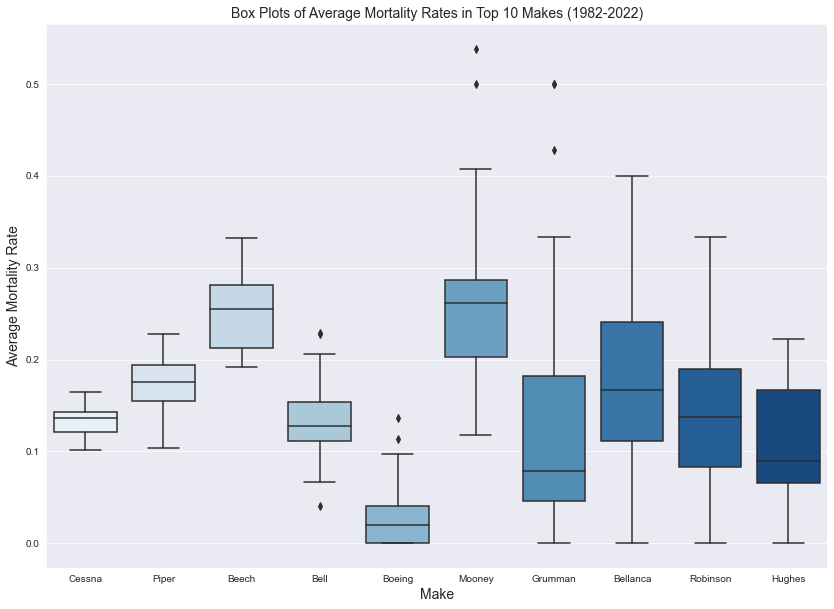

In [73]:
fig,ax=plt.subplots(figsize=(14,10))

sns.set_style('darkgrid')
sns.boxplot(data=top10_avg_rates_per_year.T, palette='Blues')

ax.set_title('Box Plots of Average Mortality Rates in Top 10 Makes (1982-2022)', fontsize=14)
ax.set_ylabel('Average Mortality Rate', fontsize=14)
ax.set_xlabel('Make', fontsize=14)
plt.show()

### Plots by Engine Count

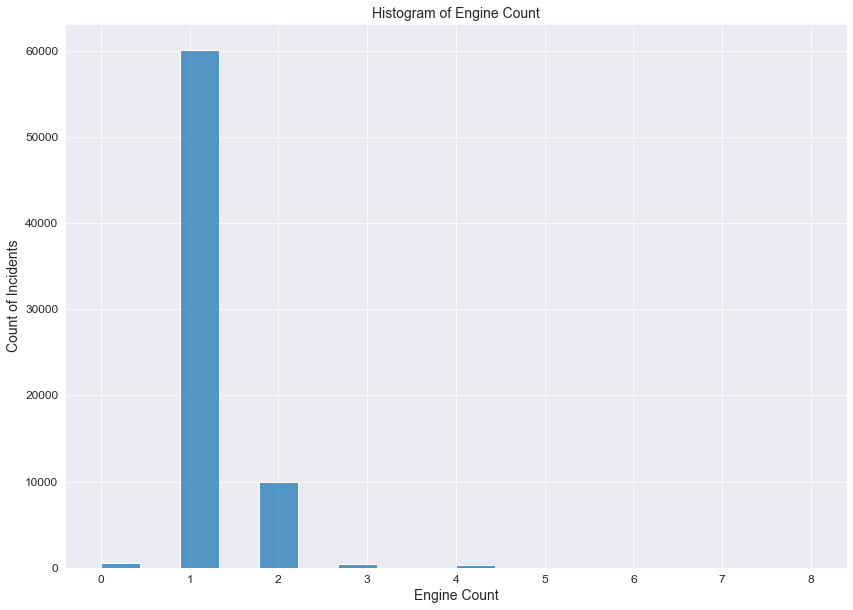

In [75]:
fig,ax=plt.subplots(figsize=(14,10))
sns.set_style('darkgrid')

sns.histplot(data=df['Number.of.Engines'])

ax.set_title('Histogram of Engine Count', fontsize=14)
ax.set_xlabel('Engine Count', fontsize=14)
ax.set_ylabel('Count of Incidents', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.show()


In [76]:
mortality_by_engines = df.groupby([df['Event.Date'].dt.year,'Number.of.Engines']).mean()['Mortality Rate'].unstack().fillna(0.0)
mortality_by_engines.drop(columns=[0.0,6.0,8.0], inplace=True)

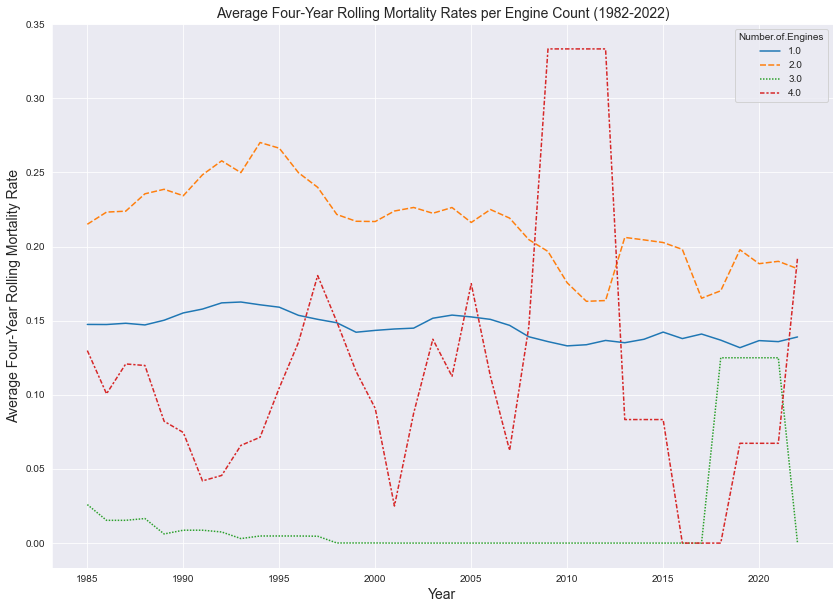

In [77]:
fig,ax=plt.subplots(figsize=(14,10))

sns.set_style('darkgrid')
sns.lineplot(data=mortality_by_engines.rolling(window=4).mean())

ax.set_title('Average Four-Year Rolling Mortality Rates per Engine Count (1982-2022)', fontsize=14)
ax.set_ylabel('Average Four-Year Rolling Mortality Rate', fontsize=14)
ax.set_xlabel('Year', fontsize=14)
plt.show()

In [84]:
count_per_no_engine_per_year = df.groupby(['Number.of.Engines',df['Event.Date'].dt.year]).count().drop(
    columns=['Event.Date']
).reset_index()

In [85]:
count_per_no_engine_per_year=count_per_no_engine_per_year.loc[count_per_no_engine_per_year['Number.of.Engines']!=0]

In [86]:
count_per_no_engine_per_year['Number.of.Engines']=count_per_no_engine_per_year['Number.of.Engines'].astype(int)

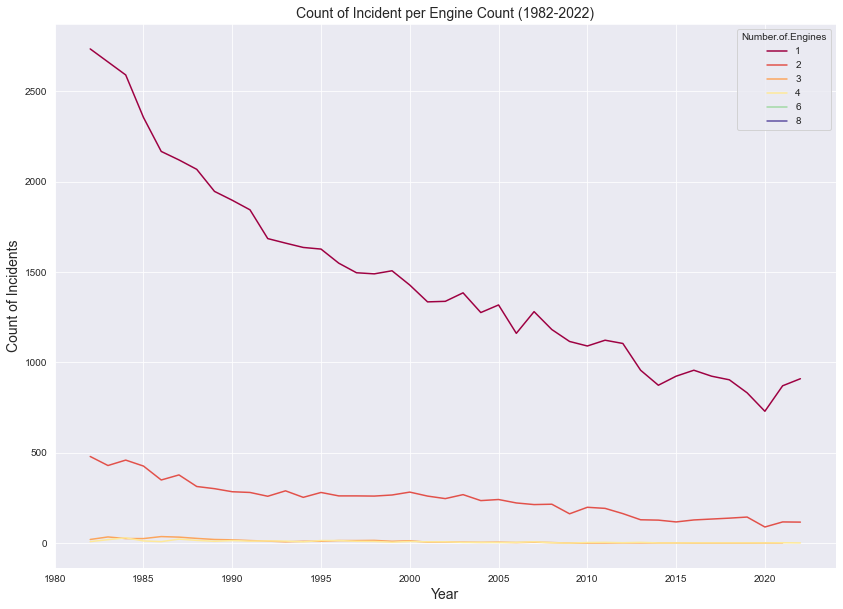

In [87]:
fig,ax=plt.subplots(figsize=(14,10))
sns.set_style('darkgrid')

count_per_no_engine_per_year_reset = count_per_no_engine_per_year.reset_index()
count_per_no_engine_per_year_reset["Number.of.Engines"] = count_per_no_engine_per_year_reset["Number.of.Engines"].astype(int)

sns.lineplot(data=count_per_no_engine_per_year_reset, x="Event.Date", y="Event.Id", hue="Number.of.Engines", palette='Spectral')
ax.set_title('Count of Incident per Engine Count (1982-2022)', fontsize=14)
ax.set_ylabel('Count of Incidents', fontsize=14)
ax.set_xlabel('Year', fontsize=14)

plt.show()

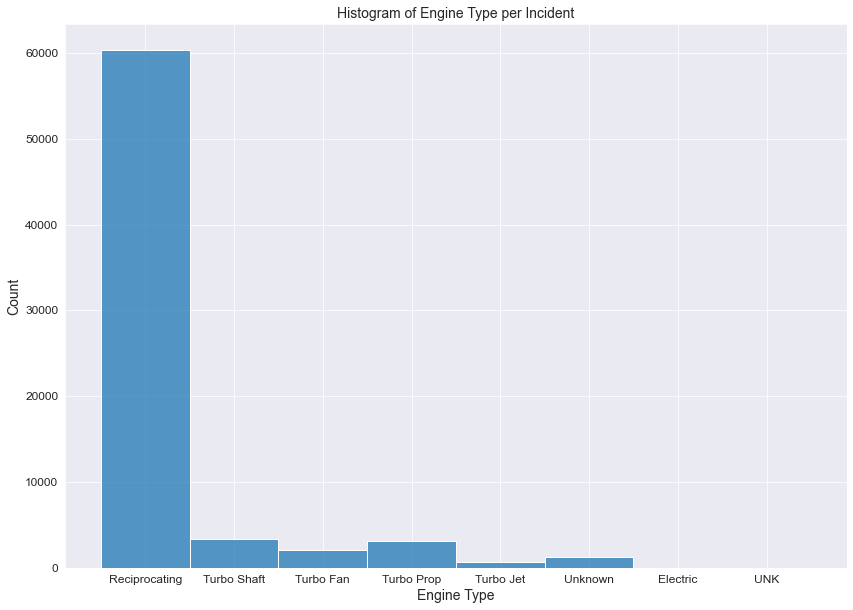

In [90]:
fig,ax=plt.subplots(figsize=(14,10))
sns.set_style('darkgrid')

sns.histplot(data=df['Engine.Type'].dropna())

ax.set_title('Histogram of Engine Type per Incident', fontsize=14)
ax.set_xlabel('Engine Type', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.show()


In [91]:
mortality_by_engine_types = df.groupby([df['Event.Date'].dt.year,'Engine.Type']).mean()['Mortality Rate'].unstack().fillna(0.0)

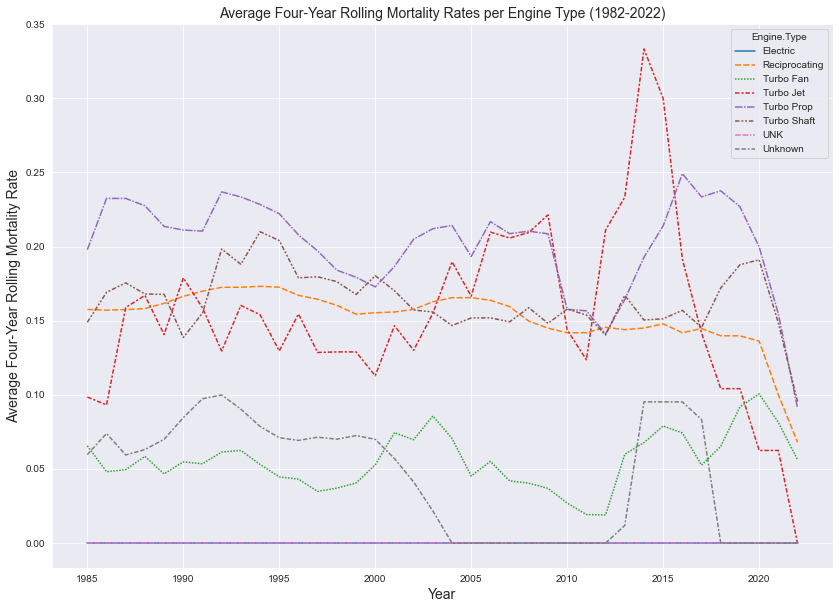

In [92]:
fig,ax=plt.subplots(figsize=(14,10))

sns.set_style('darkgrid')
sns.lineplot(data=mortality_by_engine_types.rolling(window=4).mean())

ax.set_title('Average Four-Year Rolling Mortality Rates per Engine Type (1982-2022)', fontsize=14)
ax.set_ylabel('Average Four-Year Rolling Mortality Rate', fontsize=14)
ax.set_xlabel('Year', fontsize=14)
plt.show()

### Visualizing Mortality During Flight Phases

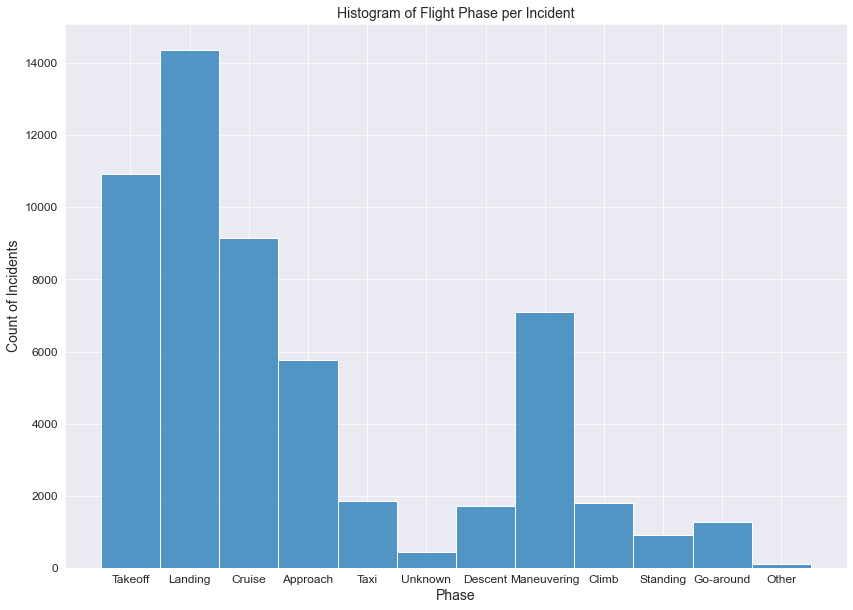

In [93]:
fig,ax=plt.subplots(figsize=(14,10))
sns.set_style('darkgrid')

sns.histplot(data=df['Broad.phase.of.flight'].dropna())

ax.set_title('Histogram of Flight Phase per Incident', fontsize=14)
ax.set_xlabel('Phase', fontsize=14)
ax.set_ylabel('Count of Incidents', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.show()


By grouping flight phases together into buckets, we see that many incidents take place close to the ground (e.g., takeoff, landing, taxi, standing, etc.). Aviasurance policies should require policyholders to have effective ground operations policies that are up to the highest safety standards,

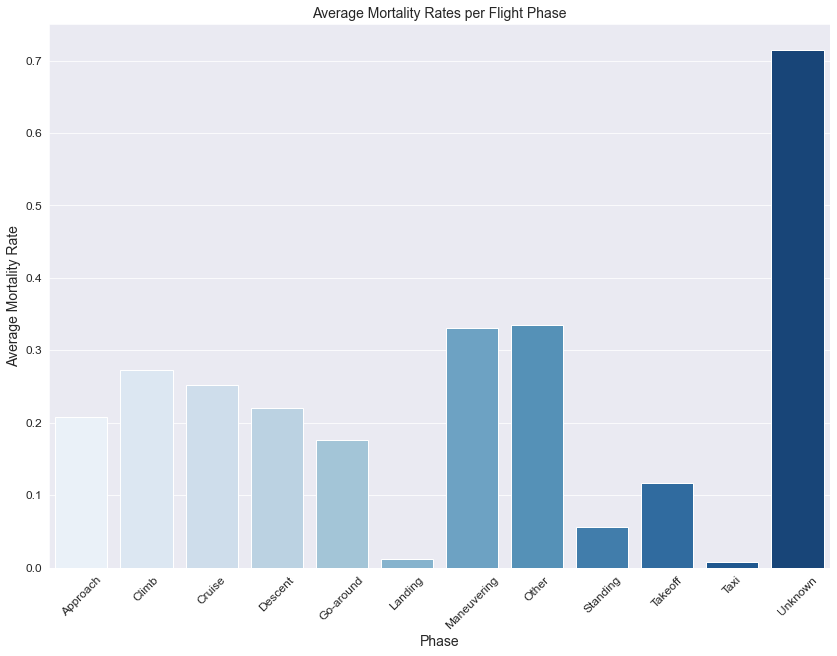

In [95]:
fig,ax=plt.subplots(figsize=(14,10))
sns.set_style('darkgrid')

df_by_phase = df.groupby('Broad.phase.of.flight').mean()

sns.barplot(data=df_by_phase, x=df_by_phase.index, y=df_by_phase['Mortality Rate'],palette='Blues')
ax.set_title('Average Mortality Rates per Flight Phase', fontsize=14)
ax.set_xlabel('Phase', fontsize=14)
ax.set_ylabel('Average Mortality Rate', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=45)
plt.show()